<a href="https://colab.research.google.com/github/dieguito1331/cienciaDatos/blob/master/UCEMA/03 - Ejercicio de Regresion Logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ==============================================
# REGRESIÓN LOGÍSTICA: Riesgo de Default (Datos Sintéticos)
# ==============================================

# 🔹 Librerías base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import statsmodels.api as sm

np.random.seed(42)



# --------------------------------------------------
# Generamos una base de clientes con variables simuladas
# --------------------------------------------------

n = 5000

# Variables explicativas
ingreso = np.random.normal(300000, 100000, n).clip(80000, 800000)       # pesos
score_crediticio = np.random.normal(600, 80, n).clip(300, 850)
antiguedad_laboral = np.random.exponential(5, n).clip(0, 30)             # años
edad = np.random.normal(40, 10, n).clip(21, 75)
monto_solicitado = np.random.normal(150000, 60000, n).clip(20000, 500000)
tasa = np.random.uniform(0.2, 0.8, n)
cant_prestamos_previos = np.random.poisson(2, n)




Porcentaje de default simulado: 7.2 %


,default,ingreso,score_crediticio,monto_solicitado,tasa,cant_prestamos_previos,antiguedad_laboral,edad
0,1,349671.415301,566.099225,109358.266277,0.535247,0,1.937550,67.359602
1,0,286173.569883,563.726871,162561.259811,0.753966,0,0.543604,45.687697
2,0,364768.853810,456.348546,117036.996963,0.506345,2,0.372581,33.701138
3,0,452302.985641,573.592785,105629.365722,0.375553,1,0.495103,43.479161
4,0,276584.662528,658.626327,109201.998304,0.413266,0,4.371779,57.806386


In [8]:
for b0 in [-3.5, -3.0, -2.5, -2.0, -1.5]:
    logit = (
        b0
        + 0.000004 * monto_solicitado
        + 2.0 * tasa
        - 0.005 * (score_crediticio - 600)
        - 0.000003 * ingreso
        + 0.03 * cant_prestamos_previos
    )
    p = 1 / (1 + np.exp(-logit))
    print(f"Intercepto = {b0:>5}  →  tasa esperada de default ≈ {p.mean()*100:.2f}%")

Intercepto =  -3.5  →  tasa esperada de default ≈ 7.13%
Intercepto =  -3.0  →  tasa esperada de default ≈ 11.07%
Intercepto =  -2.5  →  tasa esperada de default ≈ 16.68%
Intercepto =  -2.0  →  tasa esperada de default ≈ 24.23%
Intercepto =  -1.5  →  tasa esperada de default ≈ 33.67%


In [9]:
# --------------------------------------------------
# Generamos la probabilidad "real" de default
# --------------------------------------------------
# Supongamos: más ingreso y mayor score => menor default
# más tasa y más monto => más default
logit_true = (
    -3.0
    + 0.000004 * monto_solicitado
    + 2.0 * tasa
    - 0.005 * (score_crediticio - 600)
    - 0.000003 * ingreso
    + 0.03 * cant_prestamos_previos
)

# Calculamos probabilidad
p_default = 1 / (1 + np.exp(-logit_true))

# Generamos el default binario
default = np.random.binomial(1, p_default)

# Revisamos la proporción
print("Porcentaje de default simulado:", round(default.mean()*100, 2), "%")

# --------------------------------------------------
# Creamos el DataFrame final
# --------------------------------------------------
df = pd.DataFrame({
    "default": default,
    "ingreso": ingreso,
    "score_crediticio": score_crediticio,
    "monto_solicitado": monto_solicitado,
    "tasa": tasa,
    "cant_prestamos_previos": cant_prestamos_previos,
    "antiguedad_laboral": antiguedad_laboral,
    "edad": edad
})

df.head()

Porcentaje de default simulado: 11.06 %


,default,ingreso,score_crediticio,monto_solicitado,tasa,cant_prestamos_previos,antiguedad_laboral,edad
0,0,349671.415301,566.099225,109358.266277,0.535247,0,1.937550,67.359602
1,0,286173.569883,563.726871,162561.259811,0.753966,0,0.543604,45.687697
2,0,364768.853810,456.348546,117036.996963,0.506345,2,0.372581,33.701138
3,0,452302.985641,573.592785,105629.365722,0.375553,1,0.495103,43.479161
4,0,276584.662528,658.626327,109201.998304,0.413266,0,4.371779,57.806386


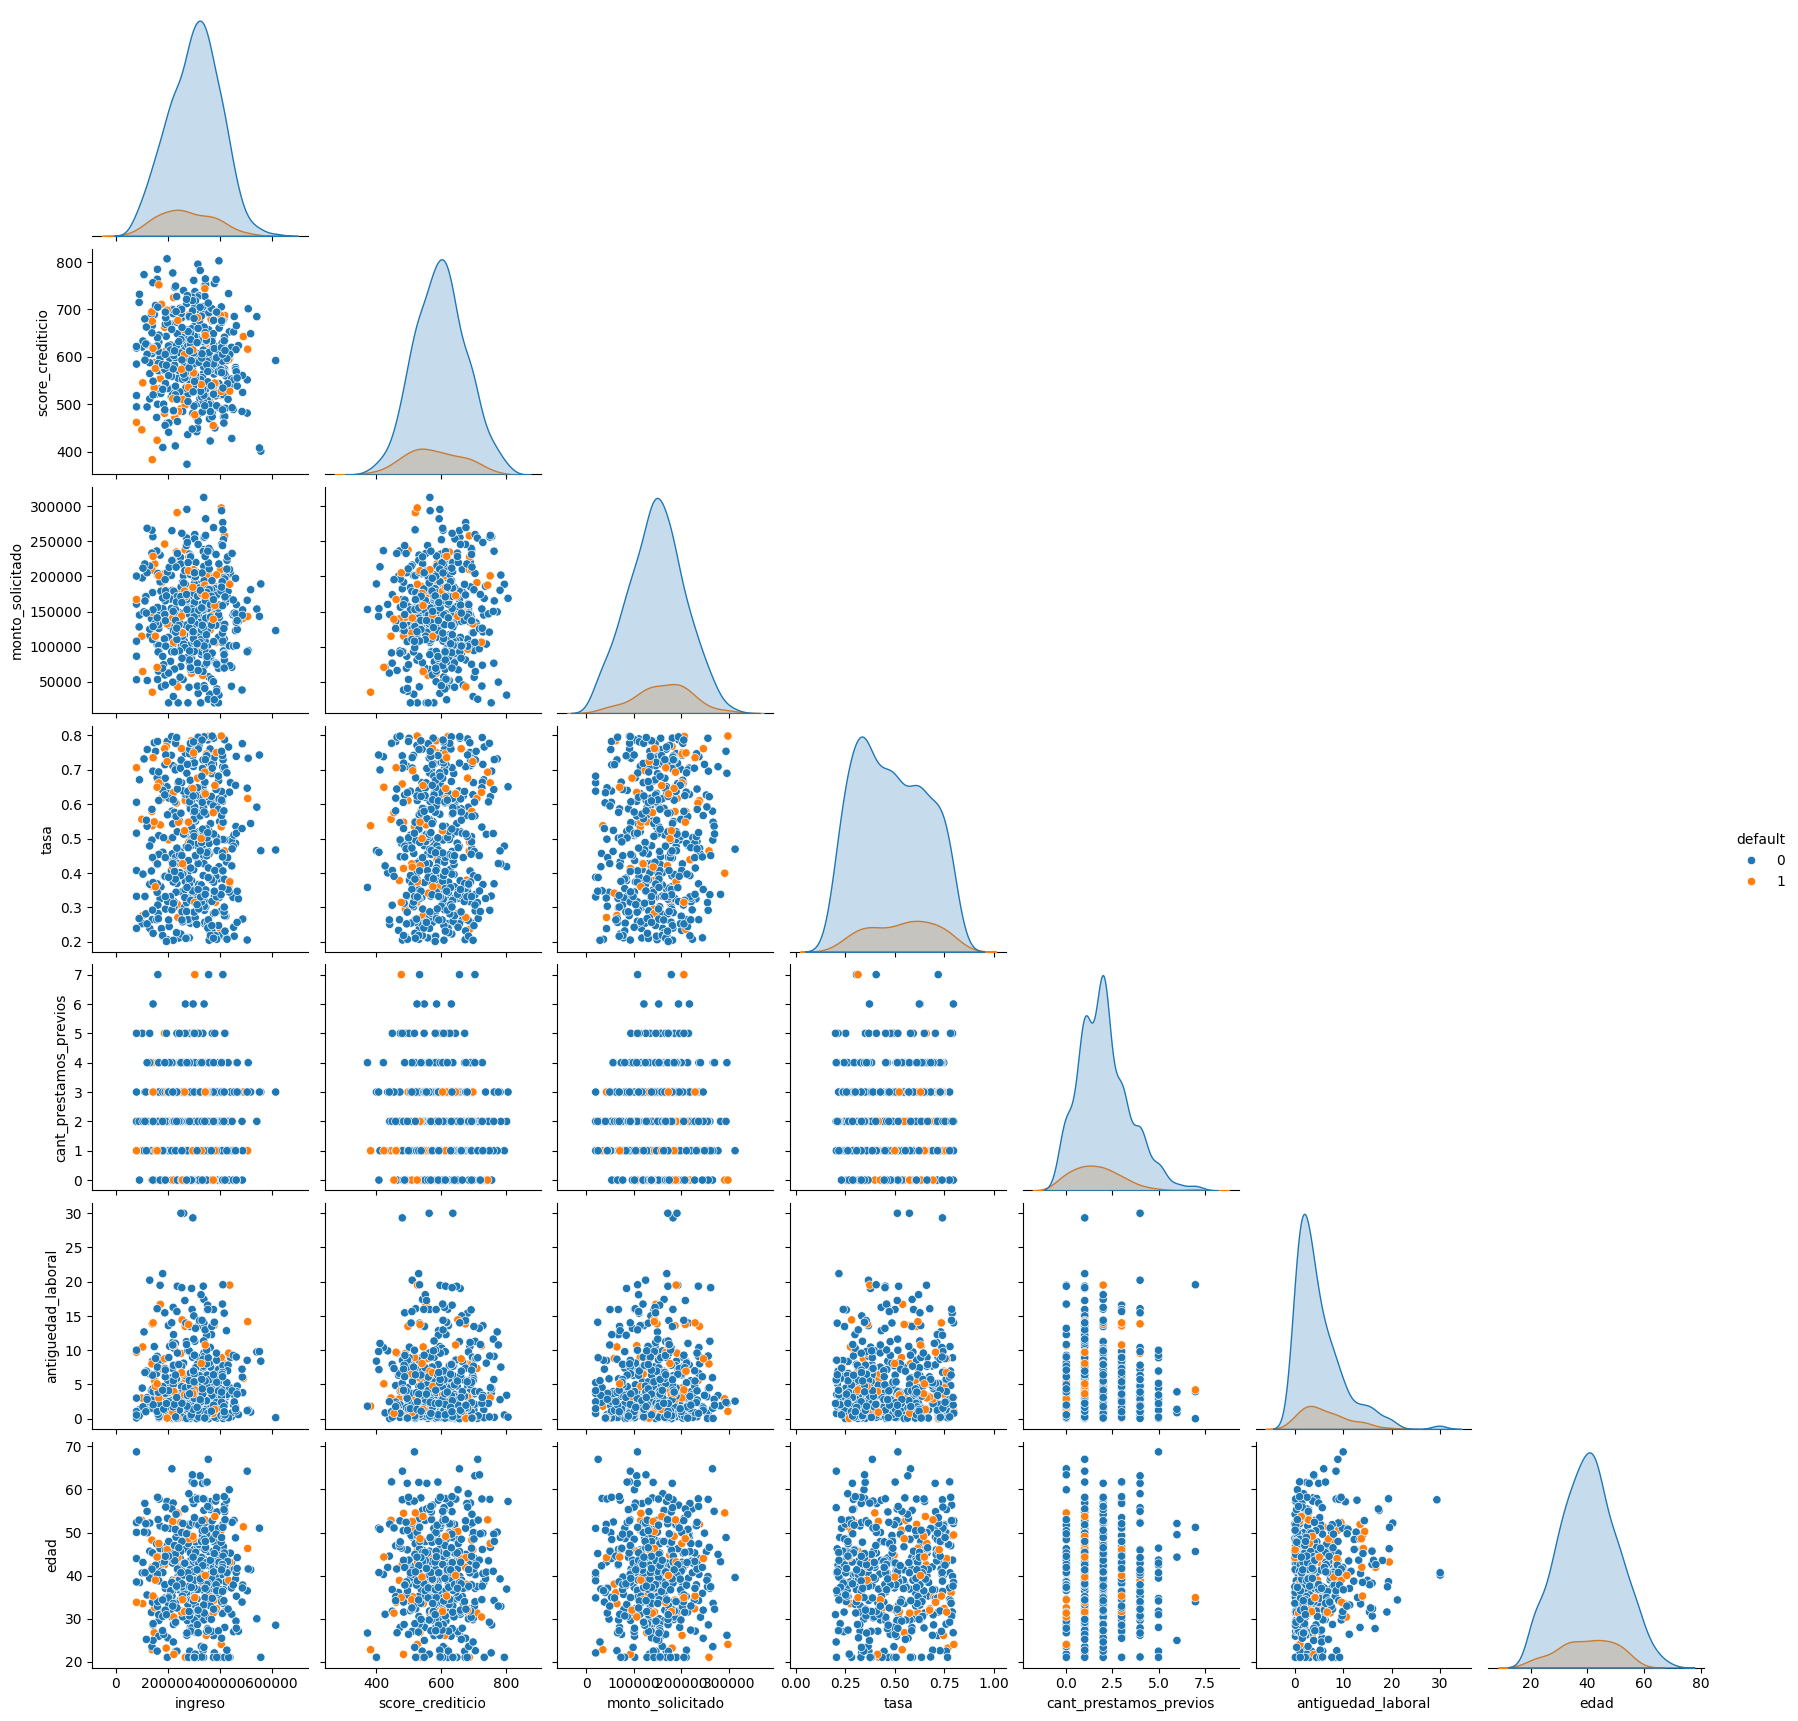

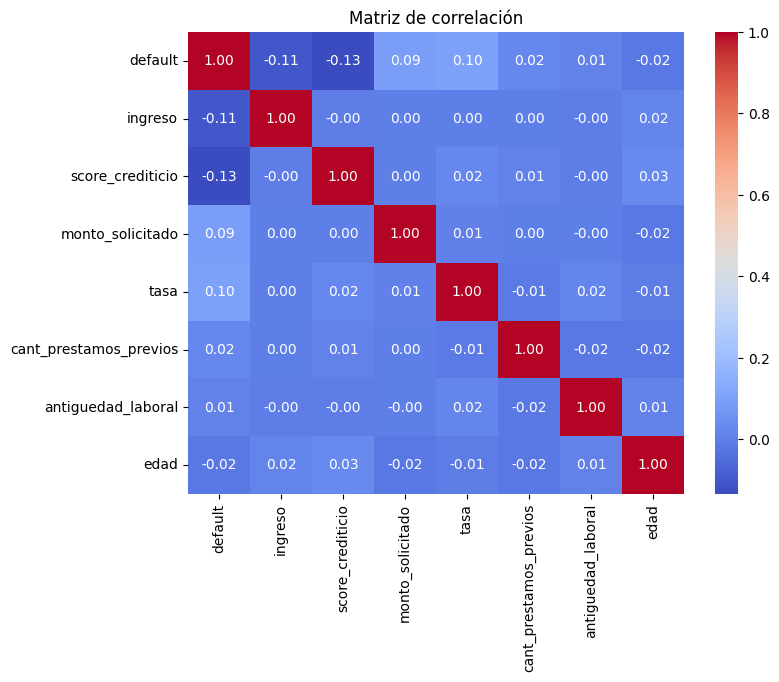

In [10]:
# --------------------------------------------------
# Distribuciones básicas
# --------------------------------------------------
sns.pairplot(df.sample(500), hue="default", diag_kind="kde", corner=True)
plt.show()

# Correlaciones
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación")
plt.show()


In [11]:
# --------------------------------------------------
# Split train-test
# --------------------------------------------------
X = df.drop(columns="default")
y = df["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# --------------------------------------------------
# Entrenamos modelo
# --------------------------------------------------
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Coeficientes
coef = pd.DataFrame({
    "Variable": X.columns,
    "Beta": model.coef_[0]
}).sort_values("Beta", ascending=False)

coef


,Variable,Beta
3,tasa,1.530794
4,cant_prestamos_previos,0.069041
2,monto_solicitado,0.000005
0,ingreso,-0.000004
5,antiguedad_laboral,-0.000159
6,edad,-0.001249
1,score_crediticio,-0.005083


Si el odds ratio es mayor que 1 → aumenta la probabilidad de default.  
Si es menor que 1 → reduce la probabilidad de default.

/tmp/ipython-input-2210335675.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Odds_ratio", y="Variable", data=coef, palette="coolwarm")


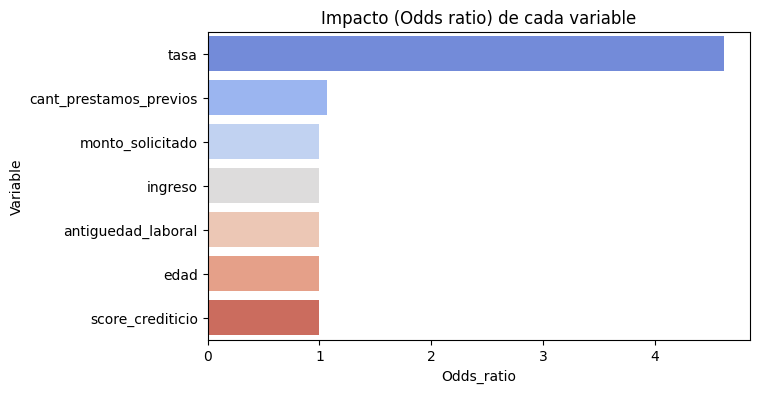

In [12]:
# --------------------------------------------------
# Interpretación: Odds ratios
# --------------------------------------------------
coef["Odds_ratio"] = np.exp(coef["Beta"])
coef = coef.sort_values("Odds_ratio", ascending=False)
coef

plt.figure(figsize=(7,4))
sns.barplot(x="Odds_ratio", y="Variable", data=coef, palette="coolwarm")
plt.title("Impacto (Odds ratio) de cada variable")
plt.show()


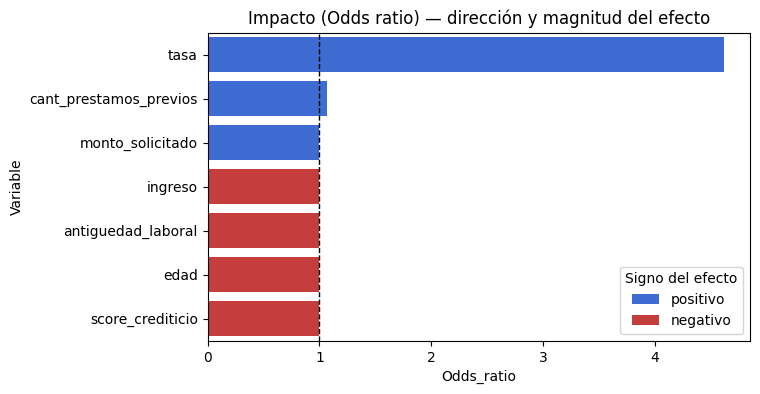

In [13]:
coef["signo"] = np.where(coef["Beta"] > 0, "positivo", "negativo")

plt.figure(figsize=(7,4))
sns.barplot(
    x="Odds_ratio", y="Variable",
    data=coef,
    hue="signo",
    dodge=False,
    palette={"positivo":"#2563eb", "negativo":"#dc2626"}  # azul vs rojo
)
plt.axvline(1, color="black", linestyle="--", linewidth=1)
plt.title("Impacto (Odds ratio) — dirección y magnitud del efecto")
plt.legend(title="Signo del efecto")
plt.show()

ROC AUC: 0.7202543306659923
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1334
           1       0.00      0.00      0.00       166

    accuracy                           0.89      1500
   macro avg       0.44      0.50      0.47      1500
weighted avg       0.79      0.89      0.84      1500



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


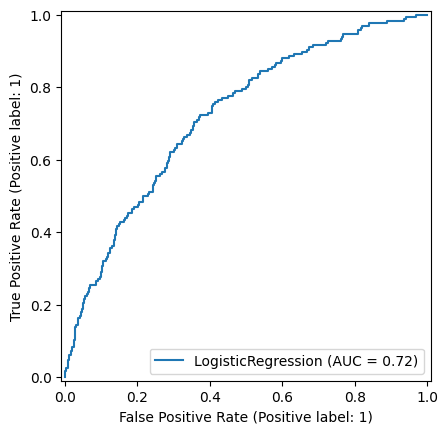

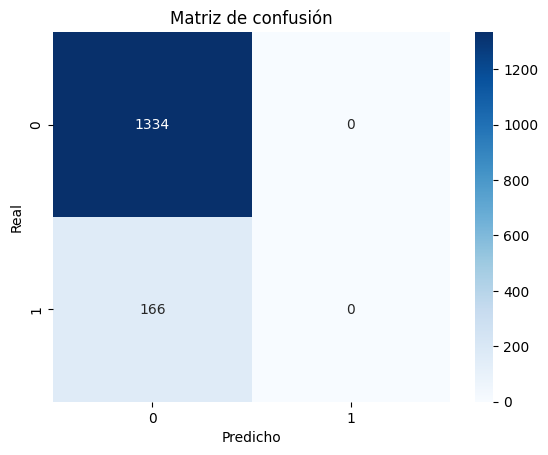

In [14]:
# --------------------------------------------------
# Predicciones y métricas
# --------------------------------------------------
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

# Curva ROC
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

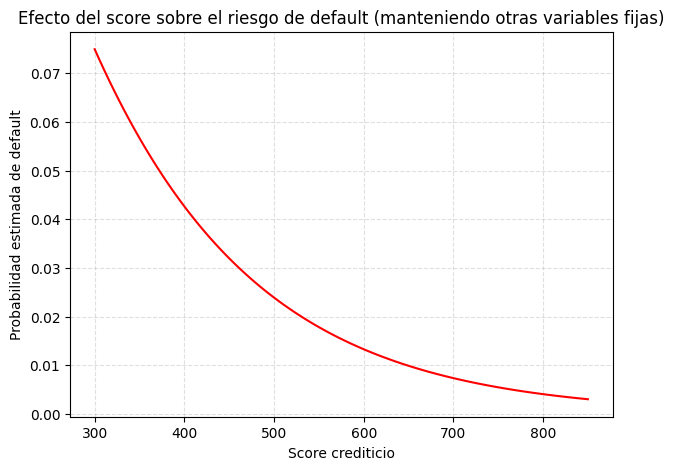

In [6]:
score_range = np.linspace(df["score_crediticio"].min(), df["score_crediticio"].max(), 100)
X_eval = df.mean().to_frame().T.loc[np.repeat(0, 100)].copy()
X_eval["score_crediticio"] = score_range

p_estimada = model.predict_proba(X_eval[X.columns])[:,1]

plt.figure(figsize=(7,5))
plt.plot(score_range, p_estimada, color="red")
plt.xlabel("Score crediticio")
plt.ylabel("Probabilidad estimada de default")
plt.title("Efecto del score sobre el riesgo de default (manteniendo otras variables fijas)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [15]:
# Probabilidades de default predichas sobre el set de test
y_prob = model.predict_proba(X_test)[:, 1]
df_test = X_test.copy()
df_test["y_real"] = y_test.values
df_test["p_default"] = y_prob

# 1️⃣ Asignar deciles (1 = más riesgoso, 10 = más seguro)
df_test["decil"] = pd.qcut(df_test["p_default"], 10, labels=False, duplicates="drop") + 1
df_test["decil"] = 11 - df_test["decil"]  # invertimos: 1 = mayor probabilidad de default

# 2️⃣ Agrupar por decil
tabla_deciles = (
    df_test.groupby("decil")
    .agg(
        clientes=("y_real", "count"),
        defaults=("y_real", "sum"),
        prob_promedio=("p_default", "mean"),
    )
    .sort_index()
)

# 3️⃣ Calcular tasas y acumulados
tabla_deciles["tasa_default"] = tabla_deciles["defaults"] / tabla_deciles["clientes"]
tabla_deciles["acum_clientes_%"] = tabla_deciles["clientes"].cumsum() / tabla_deciles["clientes"].sum()
tabla_deciles["acum_defaults_%"] = tabla_deciles["defaults"].cumsum() / tabla_deciles["defaults"].sum()

tabla_deciles = tabla_deciles.round(3)
tabla_deciles

,clientes,defaults,prob_promedio,tasa_default,acum_clientes_%,acum_defaults_%
decil,,,,,,
1,150,42,0.253,0.280,0.1,0.253
2,150,31,0.173,0.207,0.2,0.440
3,150,20,0.139,0.133,0.3,0.560
4,150,24,0.118,0.160,0.4,0.705
5,150,13,0.103,0.087,0.5,0.783
6,150,11,0.088,0.073,0.6,0.849
7,150,10,0.074,0.067,0.7,0.910
8,150,6,0.062,0.040,0.8,0.946
9,150,6,0.050,0.040,0.9,0.982


/tmp/ipython-input-3746192466.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


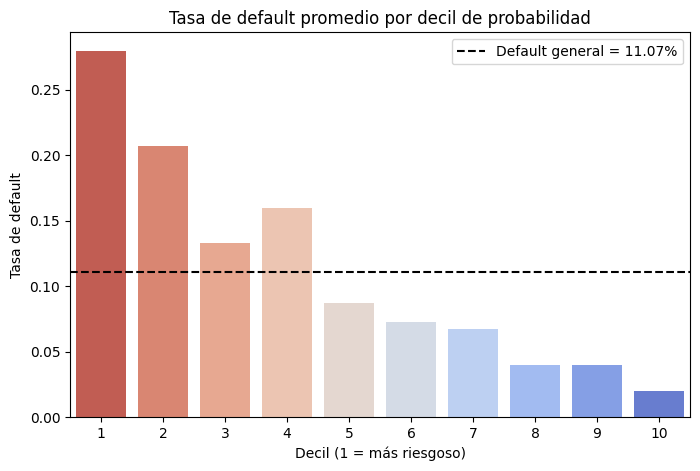

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=tabla_deciles.index,
    y="tasa_default",
    data=tabla_deciles,
    palette="coolwarm_r"
)

# Línea punteada con el default promedio general
default_general = df_test["y_real"].mean()
plt.axhline(
    y=default_general,
    color="black",
    linestyle="--",
    linewidth=1.5,
    label=f"Default general = {default_general:.2%}"
)

plt.xlabel("Decil (1 = más riesgoso)")
plt.ylabel("Tasa de default")
plt.title("Tasa de default promedio por decil de probabilidad")
plt.legend()
plt.show()

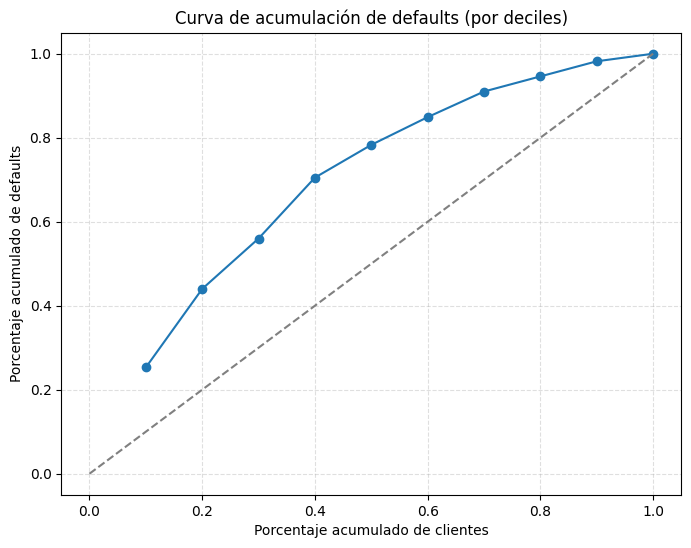

In [18]:
plt.figure(figsize=(8,6))
plt.plot(tabla_deciles["acum_clientes_%"], tabla_deciles["acum_defaults_%"], marker="o")
plt.plot([0,1],[0,1], "--", color="gray")  # diagonal de referencia
plt.title("Curva de acumulación de defaults (por deciles)")
plt.xlabel("Porcentaje acumulado de clientes")
plt.ylabel("Porcentaje acumulado de defaults")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()